In [1]:
import pyfolio as pf
%matplotlib inline
from tqdm import tqdm_notebook
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
%reload_ext autoreload
%autoreload 2

In [2]:
# -*- coding:utf-8 -*-
from abc import abstractmethod


class Agent(object):
    def __init__(self):
        pass
    
    @abstractmethod
    def trade(self, state):
        pass
    
    def train(self):
        pass
    
    @abstractmethod
    def load_model(self, model_path):
        pass
    
    @abstractmethod
    def save_model(self, model_path):
        pass

In [283]:
# -*- coding:utf-8 -*-
from agents.agent import Agent
import torch
import torch.nn as nn
import torch.optim as optim
import os


class Actor(nn.Module):
    def __init__(self, s_dim, a_dim, b_dim, n_dim, rnn_layers=1, dp=0.2):
        super(Actor, self).__init__()
        self.s_dim = s_dim
        self.a_dim = a_dim
        self.b_dim = b_dim
        self.n_dim = n_dim
        self.rnn_layers = rnn_layers
        
        self.state_gru = nn.GRU(self.s_dim, 128, self.rnn_layers, batch_first=True)
        self.fc_s_1 = nn.Linear(128, 128)
        self.fc_s_2 = nn.Linear(128, 64)
        self.fc_s_out = nn.Linear(64, 1)
        self.fc_pg_1 = nn.Linear(128, 128)
        self.fc_pg_2 = nn.Linear(128, 64)
        self.fc_pg_out = nn.Linear(64, self.a_dim)
        
        self.news_gru = nn.GRU(self.n_dim, 64, self.rnn_layers, batch_first=True)
        self.fc_n_1 = nn.Linear(64, 32)
        self.fc_n_out = nn.Linear(32, 1)
        
        self.relu = nn.ReLU()
        self.tanh = nn.Tanh()
        self.dropout = nn.Dropout(p=dp)
        self.softmax = nn.Softmax(dim=-1)
        self.initial_hidden = torch.zeros(self.rnn_layers, self.b_dim, 128, dtype=torch.float32)
    
    def forward(self, state, news, news_hidden=None, state_hidden=None, train=False):
        state, hs = self.state_gru(state, state_hidden)
        news, hn = self.news_gru(news, news_hidden)
        if train:
            state = self.dropout(state)
            news = self.dropout(news)
        sn_out = self.relu(self.fc_s_1(state))
        sn_out = self.relu(self.fc_s_2(sn_out))
        
        nn_out = self.relu(self.fc_n_1(news))
        nn_out = self.fc_n_out(nn_out)
        
        sn_out = self.fc_s_out(sn_out) * nn_out
        
        pn_out = self.relu(self.fc_pg_1(state))
        pn_out = self.relu(self.fc_pg_2(pn_out))
        pn_out = self.softmax(self.fc_pg_out(pn_out))
        return pn_out, sn_out, hs.data, hn.data


class RPGAgent(Agent):
    def __init__(self, s_dim, a_dim, b_dim, n_dim, batch_length=64, learning_rate=1e-3, rnn_layers=1):
        super().__init__()
        self.s_dim = s_dim
        self.a_dim = a_dim
        self.b_dim = b_dim
        self.n_dim = n_dim
        self.batch_length = batch_length
        self.pointer = 0
        self.s_buffer = []
        self.a_buffer = []
        self.s_next_buffer = []
        self.r_buffer = []
        self.n_buffer = []
        
        self.state_train_hidden = None
        self.state_trade_hidden = None
        self.news_train_hidden = None
        self.news_trade_hidden = None
        self.actor = Actor(s_dim=self.s_dim, a_dim=self.a_dim, b_dim=self.b_dim, n_dim=self.n_dim, rnn_layers=rnn_layers)
        self.optimizer = optim.Adam(self.actor.parameters(), lr=learning_rate)
    
    def _trade(self, state, news, train=False):
        with torch.no_grad():
            a, _, self.state_trade_hidden, self.news_trade_hidden = self.actor(state=state, news=news, news_hidden=self.news_trade_hidden, state_hidden=self.state_trade_hidden, train=False)
        if train:
            return torch.multinomial(a[:, 0, :], 1)
        else:
            return a[:, 0, :].argmax(dim=1)
    
    def trade(self, state, news, train=False):
        state_ = torch.tensor(state[:, None, :], dtype=torch.float32)
        news_ = torch.tensor(news[None, None, :], dtype=torch.float32)
        action = self._trade(state=state_, news=news_, train=train).numpy().flatten()
        return action
    
    def train(self):
        self.optimizer.zero_grad()
        s = torch.stack(self.s_buffer).t()
        s_next = torch.stack(self.s_next_buffer).t()
        r = torch.stack(self.r_buffer).t()
        a = torch.stack(self.a_buffer).t()
        n = torch.stack(self.n_buffer)[None, :, :]
        a_hat, s_next_hat, self.state_train_hidden, self.news_train_hidden = self.actor(state=s,
                                                                                        news=n,
                                                                                        state_hidden=self.state_train_hidden,
                                                                                        news_hidden=self.news_train_hidden,
                                                                                        train=True)
        mse_loss = torch.nn.functional.mse_loss(s_next_hat, s_next)
        nll = -torch.log(a_hat.gather(2, a[:, :, None]))
        pg_loss = (nll * r).mean()
        loss = mse_loss + pg_loss
        loss.backward()
        for param in self.actor.parameters():
            param.grad.data.clamp_(-1, 1)
        self.optimizer.step()
    
    def reset_model(self):
        self.s_buffer = []
        self.a_buffer = []
        self.s_next_buffer = []
        self.r_buffer = []
        self.n_buffer = []
        self.state_trade_hidden = None
        self.state_train_hidden = None
        self.pointer = 0
    
    def save_transition(self, state, action, reward, next_state, news):
        if self.pointer < self.batch_length:
            self.s_buffer.append(torch.tensor(state, dtype=torch.float32))
            self.a_buffer.append(torch.tensor(action))
            self.r_buffer.append(torch.tensor(reward[:, None], dtype=torch.float32))
            self.s_next_buffer.append(torch.tensor(next_state, dtype=torch.float32))
            self.n_buffer.append(torch.tensor(news, dtype=torch.float32))
            self.pointer += 1
        else:
            self.s_buffer.pop(0)
            self.a_buffer.pop(0)
            self.r_buffer.pop(0)
            self.s_next_buffer.pop(0)
            self.n_buffer.pop(0)
            self.s_buffer.append(torch.tensor(state, dtype=torch.float32))
            self.a_buffer.append(torch.tensor(action))
            self.r_buffer.append(torch.tensor(reward[:, None], dtype=torch.float32))
            self.s_next_buffer.append(torch.tensor(next_state, dtype=torch.float32))
            self.n_buffer.append(torch.tensor(news, dtype=torch.float32))
    
    def load_model(self, model_path='./RPG_Torch'):
        self.actor = torch.load(model_path + '/model.pkl')
    
    def save_model(self, model_path='./RPG_Torch'):
        if not os.path.exists(model_path):
            os.mkdir(model_path)
        torch.save(self.actor, model_path + '/model.pkl')

In [233]:
env=FuturesEnv(api_key="3drYqiyczNiCPcBh2CzF",instruments=['CME_SP1','CME_SP2'],start_date='2013-11-01',end_date='2018-04-10',re_download=False,commission_fee=0)

market data exist, loading


In [278]:
news_data=pd.read_csv('data/ae_embedding.csv')

news_data.index=pd.DatetimeIndex(news_data.date)

news_data.drop(['date','Last'],axis=1,inplace=True)

In [279]:
b_dim=env.preprocessed_market_data.shape[0]
s_dim=env.preprocessed_market_data.shape[-1]
n_dim=news_data.shape[-1]

In [293]:
agent=RPGAgent(a_dim=2,b_dim=b_dim,s_dim=s_dim,n_dim=n_dim,batch_length=64)

HBox(children=(IntProgress(value=0, max=20), HTML(value='')))

130071.85387681083
152061.06554852138
148587.16761417795
153767.98262090498
160669.3311238406
159088.24074886256
193028.0298889159
225357.56062818872
167369.32099113375
224821.1869538315
242257.87854973366
194257.57995793546
180999.9142071269
190190.01400034627
214776.0138630153
193816.7055572208
185288.8273315962
195691.4993381563
175976.07455021483
242965.61992687557


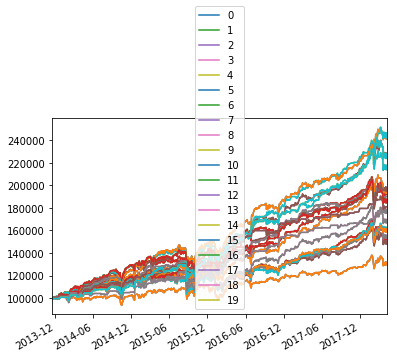

In [294]:
for e in tqdm_notebook(range(20)):
    news=np.zeros(n_dim)
    state,done=env.reset()
    news_embedding=news_data[news_data.index==str(env.current_date.date())].values.flatten()
    news[:]=news_embedding if news_embedding.shape[0]>0 else 0
    agent.reset_model()
    while not done:
        action=agent.trade(state=state,news=news,train=True)
        if action.sum()>0:
            action_normalized=np.concatenate((action,[0]))
            action_normalized=action_normalized/action_normalized.sum()
        else:
            action_normalized=np.concatenate((action,[1]))
        next_state,reward,done=env.step(action=action_normalized)
        next_log_rr=env.get_meta_state().loc['LOG_RR'].values[:,None]
        agent.save_transition(state=state,action=action,next_state=next_log_rr,reward=reward,news=news)
        state=next_state
        news_embedding=news_data[news_data.index==str(env.current_date.date())].values.flatten()
        news[:]=news_embedding if news_embedding.shape[0]>0 else 0
        if env.pointer%64==0:
            agent.train()
    pv,pp,pw=env.get_summary()
    total_pv=pv.sum(axis=1)
    total_pv.name=str(e)
    total_pv.plot(legend=True)
    print(pv.iloc[-1].sum())
    pv.sum(axis=1).plot()
    if pv.iloc[-1].sum()>400000:break

In [295]:
pv,pp,pw=env.get_summary()

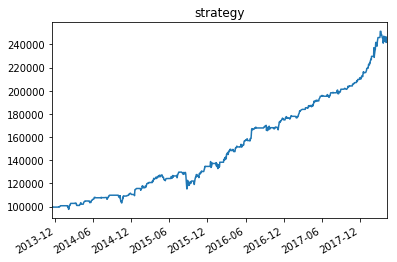

In [296]:
pv.sum(axis=1).plot()
plt.title('strategy')

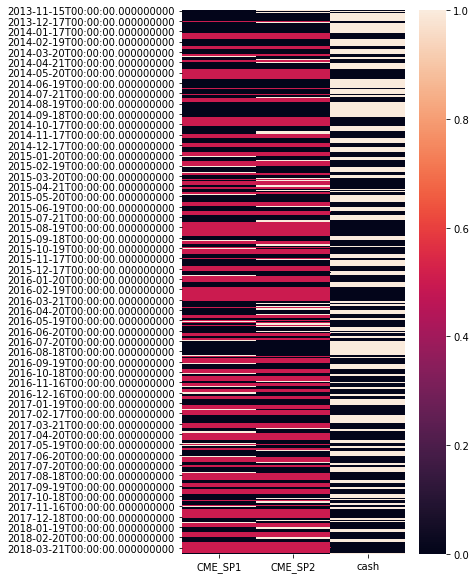

In [305]:
# pv.plot()
plt.figure(figsize=(5,10))
sns.heatmap(pw)

In [298]:
_,done=env.reset()
weight=np.concatenate((np.ones(len(env.instruments))/len(env.instruments),[0]))
while not done:
    _,_,done=env.step(action=weight)
    weight=env.current_weight

In [299]:
bpv,bpp,bpw=env.get_summary()

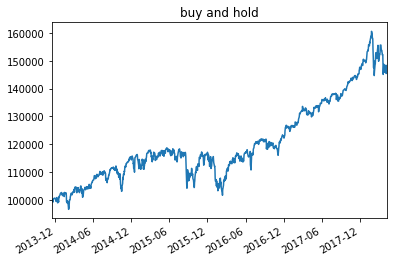

In [300]:
bpv.sum(axis=1).plot()
plt.title('buy and hold')

In [301]:
pr=pv.sum(axis=1).pct_change()
bpr=bpv.sum(axis=1).pct_change()

Entire data start date: 2013-11-18
Entire data end date: 2018-04-09
Backtest months: 52


,Backtest
Annual return,22.5%
Cumulative returns,143.0%
Annual volatility,9.9%
Sharpe ratio,2.09
Calmar ratio,2.01
Stability,0.98
Max drawdown,-11.2%
Omega ratio,1.69
Sortino ratio,3.26
Skew,-0.29


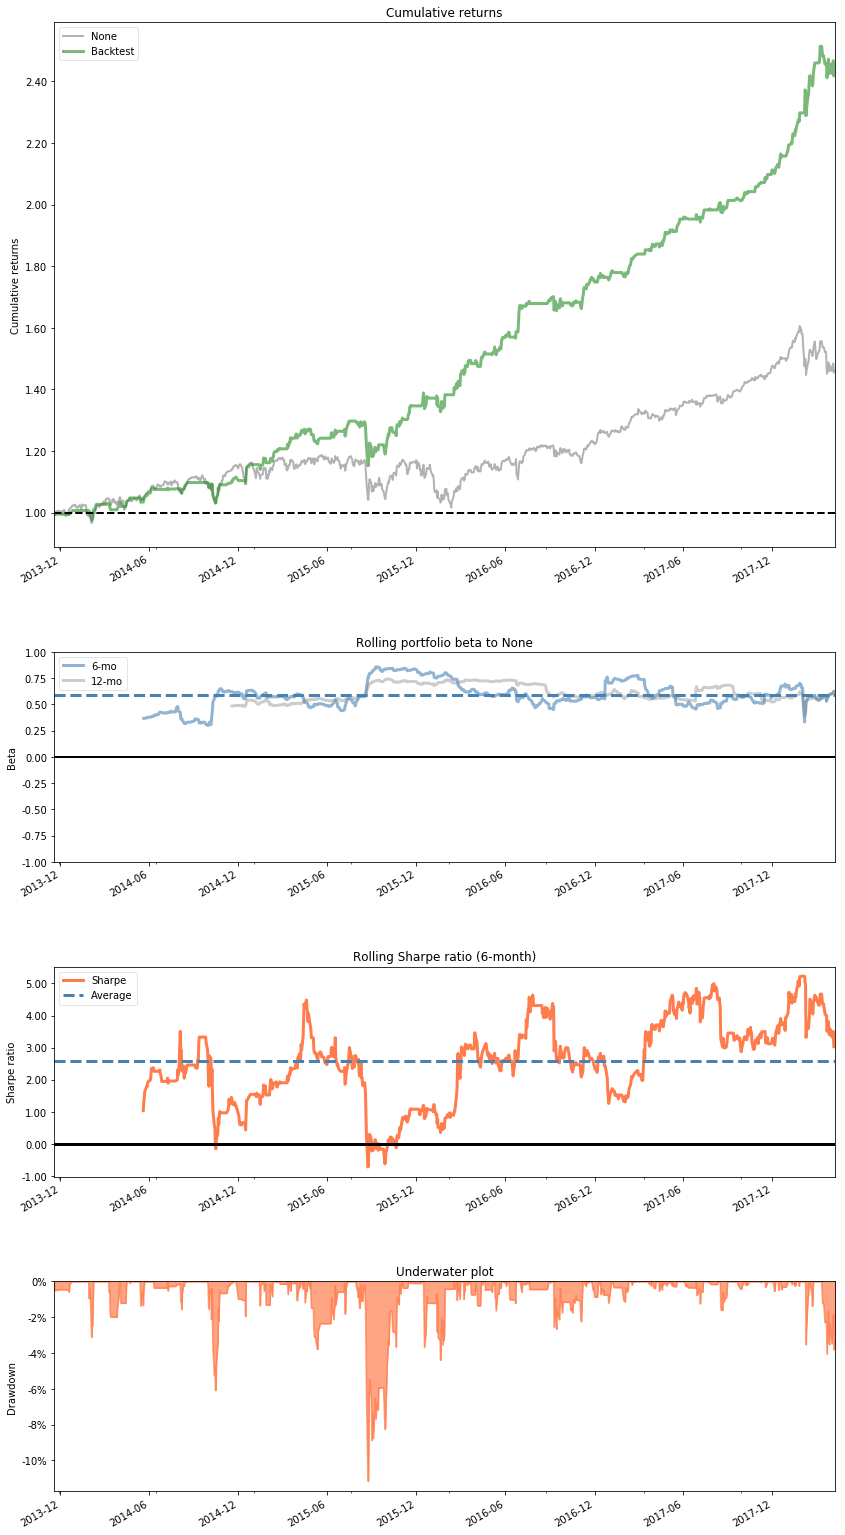

In [302]:
pf.create_simple_tear_sheet(returns=pr,benchmark_rets=bpr)

Top 10 long positions of all time,max
CME_SP1,100.00%
CME_SP2,100.00%


Top 10 short positions of all time,max


Top 10 positions of all time,max
CME_SP1,100.00%
CME_SP2,100.00%


All positions ever held,max
CME_SP1,100.00%
CME_SP2,100.00%


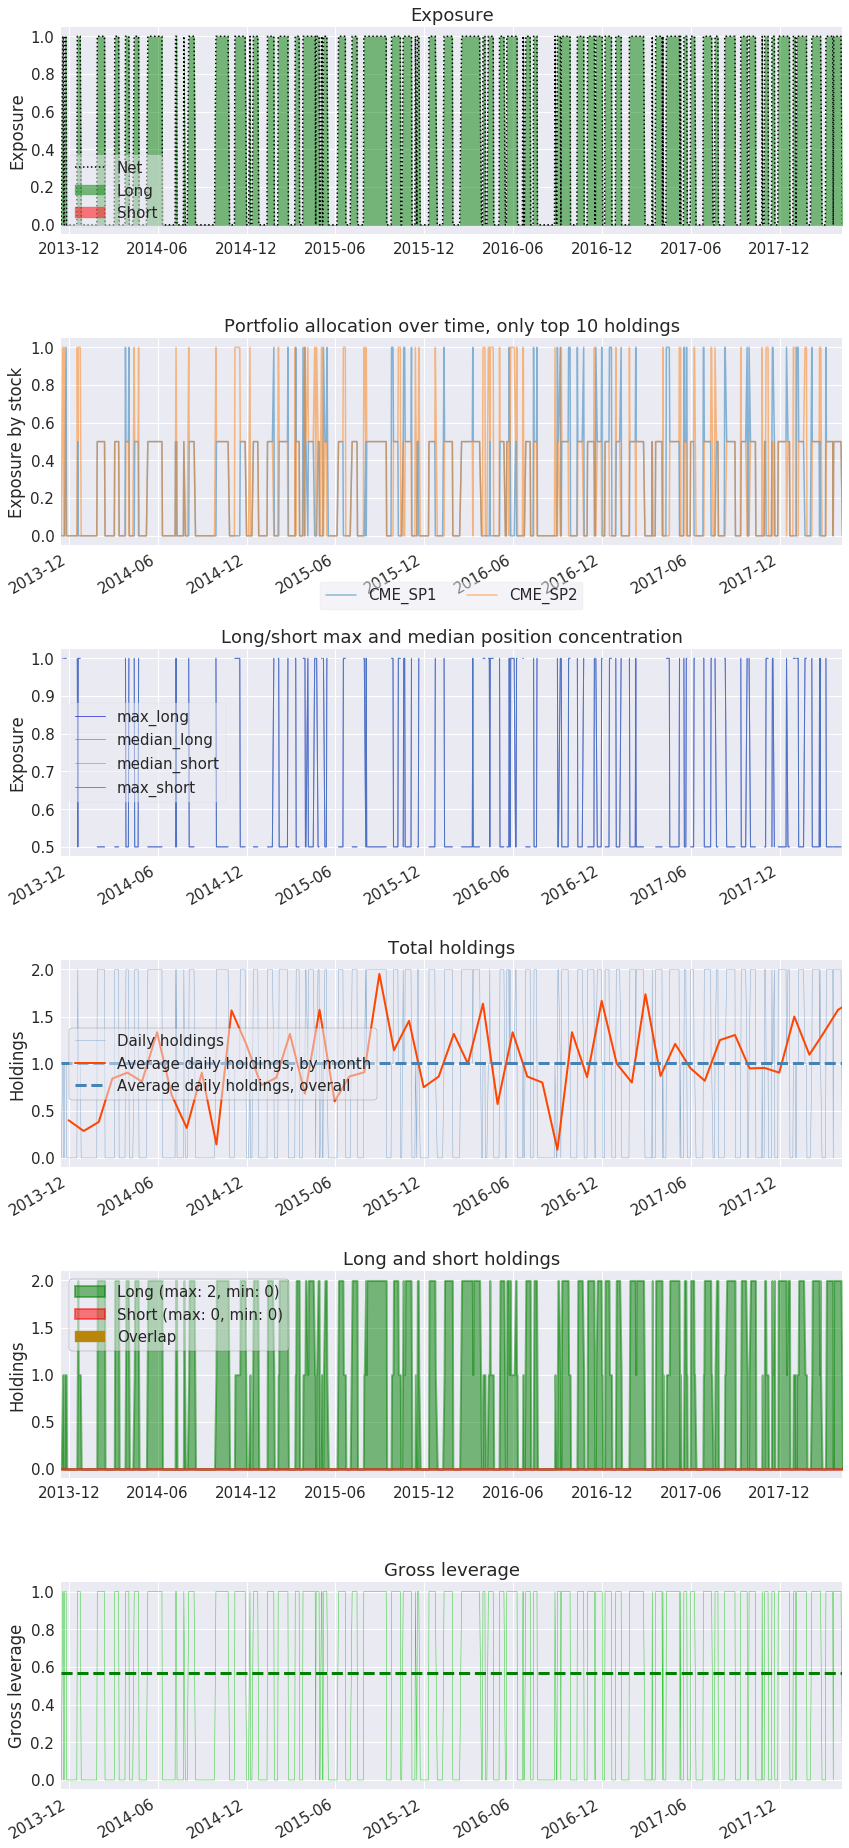

In [303]:
pf.create_position_tear_sheet(pr,pw*pv)

Stress Events,mean,min,max
Apr14,0.12%,-1.20%,0.79%
Oct14,-0.01%,-1.86%,2.03%
Fall2015,-0.18%,-5.25%,3.71%
New Normal,0.08%,-5.25%,3.71%


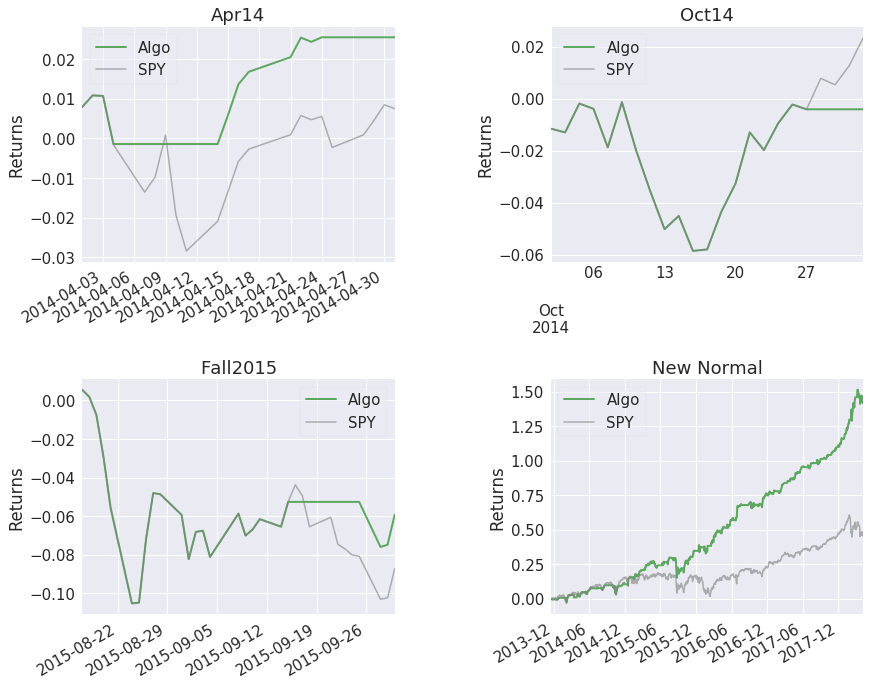

In [304]:
pf.create_interesting_times_tear_sheet(returns=pr,benchmark_rets=bpr)